In [1]:
import cvxopt as cvx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dt
from sklearn.metrics import accuracy_score #For evaluating accuracy

In [2]:

data_set = np.genfromtxt("hw06_data_set_images.csv", delimiter = ",")
labels = np.genfromtxt("hw06_data_set_labels.csv", delimiter = ",")   

In [3]:
x_train = data_set[:1000]
y_train = labels[:1000]

x_test = data_set[1000:]
y_test = labels[1000:]

number_of_bins = 64

# get number of samples and number of features
N_train = len(y_train)
D_train = x_train.shape[1]

number_of_classes  = 2

In [4]:
#calculate histogram values for train dataset 
histogram_train = np.array([(np.histogram(x_train[i], bins=number_of_bins, range=(0, 256)))[0]  for i in range(len(x_train))])/len(x_train[0])
bin_train = np.array([(np.histogram(x_train[i], bins=number_of_bins, range=(0, 256)))[1]  for i in range(len(x_train))])/len(x_train[0])
#calculate histogram values for test dataset 
histogram_test = np.array([(np.histogram(x_test[i], bins=number_of_bins, range=(0, 256)))[0]  for i in range(len(x_test))])/len(x_train[0])

print((histogram_train)[0:5,0:5])
print((histogram_test)[0:5,0:5])


[[0.86479592 0.00127551 0.         0.00255102 0.        ]
 [0.66836735 0.         0.00127551 0.00127551 0.        ]
 [0.66454082 0.00637755 0.00382653 0.00765306 0.00892857]
 [0.65816327 0.00765306 0.00892857 0.00127551 0.00382653]
 [0.5625     0.00255102 0.00255102 0.00127551 0.        ]]
[[0.68239796 0.00255102 0.00127551 0.00127551 0.00127551]
 [0.69770408 0.01658163 0.00510204 0.00382653 0.01020408]
 [0.73341837 0.02678571 0.01530612 0.00510204 0.00637755]
 [0.63903061 0.00892857 0.00255102 0.00127551 0.        ]
 [0.75382653 0.00765306 0.00127551 0.00127551 0.        ]]


In [5]:
def histogram_intersection_kernel(histogram_1, histogram_2):
    kernel = np.empty(shape=(histogram_1.shape[0], histogram_2.shape[0]), dtype=np.float64)
    for i in range(histogram_1.shape[0]):
        kernel[i] = np.sum(np.minimum(histogram_1[i], histogram_2), axis=1)
    return kernel

histogram_intersection_kernel_train= histogram_intersection_kernel(histogram_train, histogram_train)
histogram_intersection_kernel_test= histogram_intersection_kernel(histogram_test, histogram_train)
K_train = histogram_intersection_kernel(histogram_train, histogram_train)
K_test = histogram_intersection_kernel(histogram_test, histogram_train)

print(histogram_intersection_kernel_train[0:5,0:5])
print(histogram_intersection_kernel_test[0:5,0:5])

[[1.         0.72321429 0.77040816 0.75382653 0.62755102]
 [0.72321429 1.         0.73086735 0.78571429 0.68622449]
 [0.77040816 0.73086735 1.         0.84056122 0.70153061]
 [0.75382653 0.78571429 0.84056122 1.         0.76403061]
 [0.62755102 0.68622449 0.70153061 0.76403061 1.        ]]
[[0.77806122 0.80867347 0.82142857 0.88647959 0.79209184]
 [0.79464286 0.76403061 0.84566327 0.86607143 0.77933673]
 [0.8380102  0.74362245 0.85714286 0.83035714 0.68877551]
 [0.71556122 0.84438776 0.75       0.83418367 0.75765306]
 [0.84438776 0.76785714 0.82397959 0.84183673 0.73469388]]


In [6]:
# calculate Gaussian kernel
s = 1
K_train = histogram_intersection_kernel_train
K_test = histogram_intersection_kernel_test

yyK = np.matmul(y_train[:,None], y_train[None,:]) * K_train

# set learning parameters
C = 10
epsilon = 0.001

P = cvx.matrix(yyK)
q = cvx.matrix(-np.ones((N_train, 1)))
G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
A = cvx.matrix(1.0 * y_train[None,:])
b = cvx.matrix(0.0)
                    
# use cvxopt library to solve QP problems
result = cvx.solvers.qp(P, q, G, h, A, b)
alpha = np.reshape(result["x"], N_train)
alpha[alpha < C * epsilon] = 0
alpha[alpha > C * (1 - epsilon)] = C

# find bias parameter
support_indices, = np.where(alpha != 0)
active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
w0 = np.mean(y_train[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))

     pcost       dcost       gap    pres   dres
 0:  1.0887e+03 -6.1913e+04  1e+05  5e-01  4e-14
 1:  1.2396e+03 -1.1654e+04  1e+04  6e-14  4e-14
 2: -4.1568e+02 -3.9854e+03  4e+03  4e-14  3e-14
 3: -8.3426e+02 -2.5760e+03  2e+03  4e-14  4e-14
 4: -1.0562e+03 -1.7960e+03  7e+02  1e-13  4e-14
 5: -1.2018e+03 -1.4485e+03  2e+02  3e-14  5e-14
 6: -1.2586e+03 -1.3270e+03  7e+01  7e-14  5e-14
 7: -1.2782e+03 -1.2901e+03  1e+01  9e-14  6e-14
 8: -1.2826e+03 -1.2831e+03  5e-01  8e-14  6e-14
 9: -1.2828e+03 -1.2828e+03  1e-02  2e-13  6e-14
10: -1.2828e+03 -1.2828e+03  2e-04  2e-14  6e-14
Optimal solution found.


In [7]:
# calculate predictions on training samples
f_predicted = np.matmul(K_train, y_train[:,None] * alpha[:,None]) + w0

# calculate confusion matrix
y_predicted = 2 * (f_predicted > 0.0) - 1
confusion_matrix_train = pd.crosstab(np.reshape(y_predicted, N_train), y_train,
                               rownames = ["y_predicted"], colnames = ["y_train"])


# calculate predictions on training samples
f_predicted = np.matmul(K_test, y_train[:,None] * alpha[:,None]) + w0

# calculate confusion matrix
y_predicted = 2 * (f_predicted > 0.0) - 1

confusion_matrix_test = pd.crosstab(np.reshape(y_predicted, N_train), y_test,
                               rownames = ["y_predicted"], colnames = ["y_train"])

print(confusion_matrix_train)
print(confusion_matrix_test)



y_train      -1.0   1.0
y_predicted            
-1            484     9
 1              9   498
y_train      -1.0   1.0
y_predicted            
-1            466    25
 1             37   472


In [8]:
# Since we use above calculation repetedly I defined them as functions below.

def find_parameters(C):
    # calculate Gaussian kernel
    s = 10
    yyK = np.matmul(y_train[:,None], y_train[None,:]) * K_train

    # set learning parameters

    epsilon = 0.001

    P = cvx.matrix(yyK)
    q = cvx.matrix(-np.ones((N_train, 1)))
    G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
    h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
    A = cvx.matrix(1.0 * y_train[None,:])
    b = cvx.matrix(0.0)
                        
    # use cvxopt library to solve QP problems
    result = cvx.solvers.qp(P, q, G, h, A, b)
    alpha = np.reshape(result["x"], N_train)
    alpha[alpha < C * epsilon] = 0
    alpha[alpha > C * (1 - epsilon)] = C

    # find bias parameter
    support_indices, = np.where(alpha != 0)
    active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
    w0 = np.mean(y_train[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))
    
    return alpha, w0

In [9]:
def make_predictions_test_and_train(C):

    alpha, w0 = find_parameters(C)
    
    # calculate predictions on training samples
    f_predicted_train = np.matmul(K_train, y_train[:,None] * alpha[:,None]) + w0
    y_predicted_train = 2 * (f_predicted_train > 0.0) - 1
    y_predicted_train = np.reshape(y_predicted_train, N_train)
    
    # calculate predictions on training samples
    f_predicted_test = np.matmul(K_test, y_train[:,None] * alpha[:,None]) + w0
    # calculate confusion matrix
    y_predicted_test = 2 * (f_predicted_test > 0.0) - 1
    y_predicted_test = np.reshape(y_predicted_test, N_train)
    return y_predicted_train, y_predicted_test

In [10]:
# Accuracy score
def accuracy_score(predicted_y, true_y):
    score = 0
    for index in range(len(true_y)):
        if predicted_y[index] == true_y[index]:
            score += 1
    accuracy_score = float(score / len(predicted_y))
    return accuracy_score

In [11]:
c_list = [10**(-1),10**(-0.5),10**0,10**(0.5),10**1,10**(1.5),10**2,10**(2.5),10**3]
K_train = histogram_intersection_kernel(histogram_train, histogram_train)
K_test = histogram_intersection_kernel(histogram_test, histogram_train)

test_accuracies = []
train_accuracies = []

for C in c_list:
    #print(C)
    y_predicted_train , y_predicted_test = make_predictions_test_and_train(C)

    accuracy_score_train = accuracy_score(y_predicted_train, y_train)
    train_accuracies.append(accuracy_score_train)

    accuracy_score_test = accuracy_score(y_predicted_test, y_test)
    test_accuracies.append(accuracy_score_test)



0.1
     pcost       dcost       gap    pres   dres
 0: -1.8751e+02 -2.4438e+02  7e+03  3e+01  5e-15
 1: -6.2127e+01 -2.2353e+02  5e+02  1e+00  4e-15
 2: -4.8341e+01 -1.2857e+02  8e+01  6e-16  1e-15
 3: -5.3798e+01 -6.6369e+01  1e+01  2e-16  9e-16
 4: -5.7212e+01 -6.1182e+01  4e+00  3e-16  8e-16
 5: -5.8516e+01 -5.9343e+01  8e-01  2e-16  9e-16
 6: -5.8814e+01 -5.8991e+01  2e-01  1e-15  1e-15
 7: -5.8883e+01 -5.8910e+01  3e-02  2e-15  1e-15
 8: -5.8895e+01 -5.8897e+01  2e-03  3e-15  1e-15
 9: -5.8896e+01 -5.8896e+01  3e-05  2e-15  1e-15
Optimal solution found.
0.31622776601683794
     pcost       dcost       gap    pres   dres
 0: -2.1663e+02 -7.2291e+02  8e+03  8e+00  5e-15
 1: -1.1031e+02 -6.1711e+02  7e+02  3e-01  4e-15
 2: -1.1254e+02 -1.8088e+02  7e+01  1e-02  2e-15
 3: -1.2553e+02 -1.5831e+02  3e+01  5e-03  2e-15
 4: -1.3428e+02 -1.4269e+02  9e+00  1e-03  2e-15
 5: -1.3682e+02 -1.3946e+02  3e+00  2e-04  2e-15
 6: -1.3789e+02 -1.3812e+02  2e-01  3e-06  3e-15
 7: -1.3799e+02 -1.3800

[0.849, 0.896, 0.931, 0.934, 0.938, 0.923, 0.922, 0.921, 0.921]


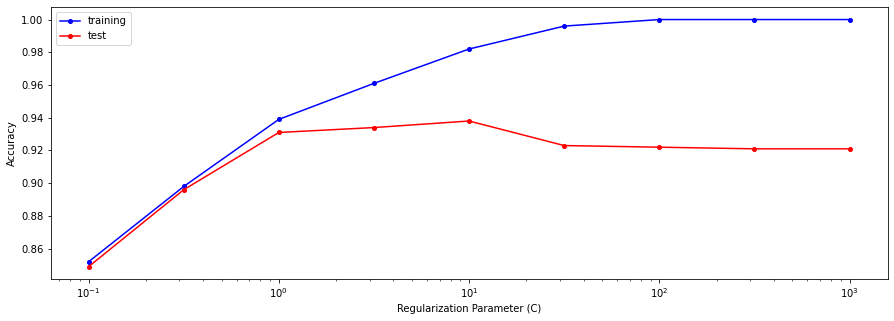

In [12]:
#print(test_accuracies) #[0.849, 0.896, 0.931, 0.934, 0.938, 0.923, 0.922, 0.921, 0.921]

plt.figure(figsize=(15, 5))

"""
plt.plot(c_list, train_accuracies, color = "blue", label="training")  
plt.scatter(c_list, train_accuracies, color = "blue", linewidths=2) 

plt.plot(c_list, test_accuracies, color = "red", label="test") 
plt.scatter(c_list, test_accuracies, color = "red", linewidths=2) 
"""
plt.plot(c_list, train_accuracies, "-ob", markersize=4, label='training')
plt.plot(c_list, test_accuracies, "-or", markersize=4, label='test')
plt.xscale('log')
plt.xlabel("Regularization Parameter (C)")
plt.ylabel("Accuracy")
plt.legend(loc='upper left')
plt.show()